# Time Series from Scratch
The goal of this notebook is to start from some basics that many of us know and build a basic knowledge about time series. This gives us power to handle many different timeseries with appropriate technique.

The assumption is that we know
- Random Walk
- Fourier Series
- Fourier Transform

#### Example of timeseries:
- daily outdoor temperature
- stock market
- exchange rate (e.g. dollar to euro)
- piece of music

#### What kind of problem:
- Prediction:
    - Price for tomorrow
    - Revenue of the next month
    - Tomorrow's temperature
    - Mimic the style of music (generate a new music in the same genre)
    - Predicting text
- Classification:
    - Anomaly detection

#### Why do we treat timeseries differently?
Many problems in DS are time-dependent, house pricing, customer churn, ... 
- slow & fast change
- strong auto-correlation between past, present, and it is expected to be also future.
- hypothesis that either time is the most important feature or many other features also depend on time. 


### More Formal Definition
A basic definition of timeseries can be given as a time-dependent dataset that persumably evey data point is a stochastic function of past points. In other words
$$
y_i = f(y_{i-1}, y_{i-2}, \ldots)
$$

A process that each point has a non-zero correlation with data in past. Let consider a simple example of $y_i = y(t_i) = A\sin(t_i)$. The next time step would be 
$$
y_{i+1} = y_i + \Delta t
$$
We can realize

\begin{align}
y_{i+1} &= y(t_{i+1}) = A\sin(t_{i+1})\\
&=A\sin(t_i + \Delta t) \\
&= A y_i\cos(\Delta t) + \sqrt{1-y^2} \sin(\Delta t)\\
&= A[y_i + \Delta(1 - y_i^2)^{1/2}]
\end{align}
where is the last line we use the fact that for $\Delta t \ll 1$, $\sin(\Delta t) = \Delta t, \text{and } \cos(\Delta t) = 1$.


### What is correlation?
Let imagine a random variable $X$, the distribution of generated points by such process is described by a density function of $\rho(x)$, the number of points in the range $x$ and $x+dx$ equals
$$ \rho(x)dx $$

Now, let consider two random variables $X$ and $Y$, the joint distribution of two variable is described by 
$$\rho(x,y)$$

In case that two variables are independent, the joint probability can be written as multiplication of each distribution 
$$\rho(x,y) = \rho(x)\rho(y)$$. The correlation between two random variables is defined as 
$$corr(x,y) = \int dx \int dy (x-\bar{x})(y-\bar{y})\rho(x,y)$$
If the random varibles are independent then the correlation as it is expected would be zero
\begin{aligned}
    corr(x,y) &= \int dx \int dy (x-\bar{x})(y-\bar{y})\rho(x,y)\\
              &= \int dx (x-\bar{x})\rho(x) \int dy (y-\bar{y})\rho(y)\\
              &= 0\times 0
\end{aligned}

If $x$ and $y$ are not indepenedent, can we get anything intresting from conditional probability
$$ p(x|y) = \frac{p(x,y)}{p(y)}$$

Time-series can be seen as a supervised learning with features of $y_{i-l}, \ldots, y_i$ and target of $y_{i+1}$ or
$$ y_{i+1} = f(y_i, \ldots, y_{i-l}) $$

It is expected that the autocorrelation between two elements of a time-series will be exponentially decrease by the distance.
$$corr(y_i, y_{i+1}) \propto e^{-l}$$

To test this hypothesis let generate a random walk then test

## Generating Data

In [11]:
import numpy as np
import matplotlib.pyplot as pl

import pandas as pd

In [12]:
def rw_generator(N: int, x_0 = 0, p_left=0.5):
    """ generates N steps according to probability to take a step to 
    left with p_left and to right 1-p_left
    
    input:
    ------
    N(int): Number of steps
    x_0(int): initial position
    p_left(float): probability to take a step left
    
    return:
    -------
    array(N): random walk series
    """
    steps = [x_0] + [ 1 if (i>p_left) else -1 for i in np.random.random(N-1)]
    return np.add.accumulate(steps)

In [13]:
# Fourier series 
def periodic_generator(coeffs: list, x):
    """generates a fourier series for given coefficient
    input:
    ======
    coeffs(list): list of coefficient
    x(N): np array
    return:
    =======
    y(N): np array
    """
    y = np.zeros(x.shape[0])
    num_terms = len(coeffs)
    for i in range(num_terms):
        y += coeffs[i]*np.sin(i*x)
    return y

In [14]:
# random coefficient generator
def coeff_generator(N:int):
    return np.random.rand(N).tolist()

In [15]:
# trend 
def trend_generator(coeffs: np.array, x: np.array):
    """generates a trend for given coefficient for polynomial terms
    input:
    ======
    coeffs(np.array): list of polynomial coeeficient
    x(N): np array
    return:
    =======
    y(N): np array
    """
    i = 1
    y = np.zeros(x.shape[0])
    for l in coeffs:
        y += l * x**i
        i +=1
    return y

In [16]:
coeff_generator(3)

[0.6122450967572403, 0.6108769506488902, 0.2760974983178477]

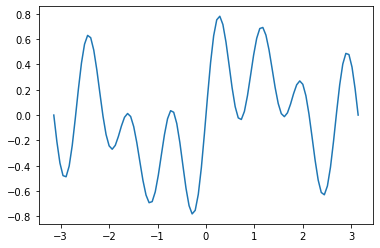

In [17]:
coeffs = [0.1, 0.2, 0.3, 0, 0, 0.2, 0.0, 0.4]
x = np.linspace(-np.pi, np.pi,100)
y = periodic_generator(coeffs, x)

pl.plot(x,y)
pl.show()

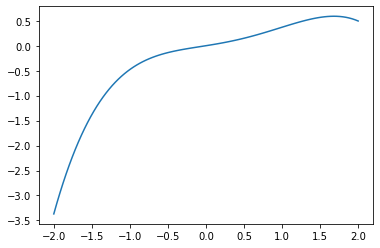

In [18]:
coeffs = [0.1, 0.2, 0.3, 0, 0, 0.2, 0.0, 0.4]
x = np.linspace(-2, 2,100)
y = trend_generator(coeffs = 0.5 - np.random.rand(4), x=x)

pl.plot(x,y)
pl.show()

In [19]:
Y = rw_generator(1000)

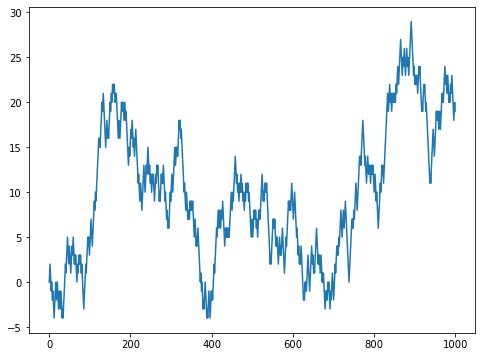

In [20]:
fig  = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(Y)
pl.show()

### Time-series generator
Three important element
- [X] stochastic
- [X] periodic
- [X] trend

These element can come togheter as an `additive` or `multiplitive` model.

Asymmetric random walk that can lead to trend. 

In [21]:
class TimeSeries:
    """ class to generate a timeseries. It can have any or all components of
    - random walk
    - fourier terms (sin)
    - trend, a slow funcition that envlope the others
    """
    
    #########
    def __init__(self, random_walk=True, frourier_term=True, trend=True, length=100):
        # random-walk component         
        self.rw_cmp = rw_generator(N = length)
        # fourier component
        coeffs = coeff_generator(4)
        x = np.linspace(0, 2*np.pi, length)
        self.fr_cmp = periodic_generator(coeffs = coeffs, x=x )
        # trend component
        x = np.linspace(-2, 2,length)
        self.trend_cmp = trend_generator(coeffs = 0.5 - np.random.rand(4), x=x)
        
        self.ts_array = self.rw_cmp + self.fr_cmp + self.trend_cmp
        
    ##########  
    # random-walk generator
    ##########  
    def rw_generator(N: int, x_0 = 0, p_left=0.5):
        """ generates N steps according to probability to take a step to 
        left with p_left and to right 1-p_left

        input:
        ------
        N(int): Number of steps
        x_0(int): initial position
        p_left(float): probability to take a step left

        return:
        -------
        array(N): random walk series
        """
        steps = [x_0] + [ 1 if (i>p_left) else -1 for i in np.random.random(N-1)]
        return np.add.accumulate(steps)

    ##########
    # Fourier series 
    ##########
    def periodic_generator(coeffs: list, x):
        """generates a fourier series for given coefficient
        input:
        ======
        coeffs(list): list of coefficient
        x(N): np array
        return:
        =======
        y(N): np array
        """
        y = np.zeros(x.shape[0])
        num_terms = len(coeffs)
        for i in range(num_terms):
            y += coeffs[i]*np.sin(i*x)
        return y
    
    ##########
    # random coefficient generator
    ##########
    def coeff_generator(N:int):
        """generate a list of random numbers
        N: length of list
        """
        return np.random.rand(N).tolist()
    ##########
    # trend generator
    ##########
    def trend_generator(coeffs: np.array, x: np.array):
        """generates a trend for given coefficient for polynomial terms
        input:
        ======
        coeffs(np.array): list of polynomial coeeficient
        x(N): np array
        return:
        =======
        y(N): np array
        """
        i = 1
        y = np.zeros(x.shape[0])
        for l in coeffs:
            y += l * x**i
            i +=1
        return y

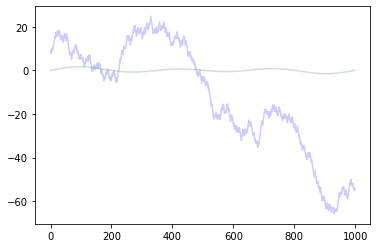

In [22]:
ts1 = TimeSeries(length=1000)
pl.plot(ts1.ts_array, color='blue',alpha=0.2)
# pl.plot(ts1.rw_cmp , color='green',alpha=0.2)
pl.plot(ts1.fr_cmp , color='green',alpha=0.2)


In [24]:
# ts1.ts_array

In [26]:
N = Y.shape[0]
crr = []
for l in range(1,200,10):
    yi = Y[0:N-l]
    yil = Y[l:N]
    crr.append( np.corrcoef(yi, yil)[0,1] )
    
crr;

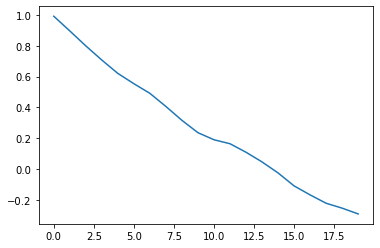

In [27]:
pl.plot(range(20),crr)
# It was expected that the corrlation would decrease by increasing the distance, but apparntly it did not.

## Data Analysis

Metrics for Data Analysis:
- Auto-Correlation
- Decomposition

## Modelling

In [35]:
def moving_window(x: np.array, window: int):
    reduce_size = x.shape[0] - window
    x_mtx = np.zeros((reduce_size,window))
    y_mtx = np.zeros(reduce_size)
    for i in range(reduce_size):
        x_mtx[i,:] = x[i:i+window]
        y_mtx[i] = x[i+window]
    return x_mtx, y_mtx

In [36]:
x = np.linspace(1,100,100)

In [41]:
xx, yy = moving_window(x, 4)

In [45]:
xx.shape[0] == yy.shape[0]

True